### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display
pd.plotting.register_matplotlib_converters()
from pandas.plotting import register_matplotlib_converters

### Read dataset

In [4]:
df1 = pd.read_csv("./df1.csv")
df2 = pd.read_csv("./df2.csv")
attrition = pd.read_csv("./attrition.csv")

### Data preprocessing

In [5]:
indexes_df2 =  df2.loc[pd.isna(df2.Attrition) == True, "EmployeeNumber"]
indexes_attrition = attrition.loc[pd.isna(attrition.Attrition) == True, "EmployeeNumber"]

In [6]:
df2.dropna(inplace=True)
df1 = df1[df1["EmployeeNumber"].isin(indexes_df2) == False]

In [7]:
df1.drop(['EmployeeCount', 'DistanceFromHome'], axis=1, inplace=True)
df2.drop(['Over18', 'StandardHours'], axis=1, inplace=True)

In [8]:
# df1.drop("Age", axis=1, inplace=True)
# df2.drop("YearsInCurrentRole", axis=1, inplace=True)
# df2.drop("YearsSinceLastPromotion", axis=1, inplace=True)

##### Deleting outliers

In [9]:
df2 = df2[df2["YearsAtCompany"] < 60]
df2 = df2[df2['YearsWithCurrManager'] <= 17]
df2 = df2[df2['TotalWorkingYears'] <= 40]

In [10]:
# def repair(x):
#     if x > 500:
#         x = x / 360
#     return int(x)

In [11]:
# df2["TotalWorkingYears"] = df2["TotalWorkingYears"].apply(lambda x: repair(x))
# df2["YearsAtCompany"] = df2["YearsAtCompany"].apply(lambda x: repair(x))
# df2["YearsInCurrentRole"] = df2["YearsInCurrentRole"].apply(lambda x: repair(x))
# df2["YearsSinceLastPromotion"] = df2["YearsSinceLastPromotion"].apply(lambda x: repair(x))
# df2["YearsWithCurrManager"] = df2["YearsWithCurrManager"].apply(lambda x: repair(x))
# df1["Age"] = df1["Age"].apply(lambda x: repair(x))

### Categorical columns

In [12]:
df1['Department'] = df1['Department'].replace({
    'Research & Development': 0, 
    'Human Resources': 1, 
    'Sales': 2 })

df1['BusinessTravel'] = df1['BusinessTravel'].replace({
    'Non-Travel': 0, 
    'Travel_Rarely': 1, 
    'Travel_Frequently': 2 })

df1['EducationField'] = df1['EducationField'].replace({
    'Life Sciences': 0, 
    'Human Resources': 1,
    'Marketing': 2,
    'Medical': 3,
    'Technical Degree': 4,
    'Other': 5 })

df1['Gender'] = df1['Gender'].apply(lambda x: 1 if x == 'Female' else 0) 

df1['MaritalStatus'] = df1['MaritalStatus'].replace({
    'Divorced': 0, 
    'Single': 1, 
    'Married': 2 })


df2['Attrition'] = df2['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

df2['OverTime'] = df2['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0) 

In [13]:
df1['JobRole'] = df1['JobRole'].astype('category').cat.codes

##### Split the dataframe into the train and test groups

In [14]:
X_test = df2[-400:]
X_train = df2[:-400]

y_test = X_test["Attrition"]
y_train = X_train["Attrition"]

X_test.pop("Attrition")
X_train.pop("Attrition")

0       0
1       0
2       0
3       0
4       0
       ..
3896    0
3897    0
3898    1
3899    0
3900    1
Name: Attrition, Length: 3122, dtype: int64

**Decision Tree df2** 

In [15]:
clf = DecisionTreeClassifier()

if 'EmployeeNumber' in X_train.columns:
    X_train.drop("EmployeeNumber", axis=1, inplace=True)

if 'EmployeeNumber' in X_test.columns:
    X_test.drop("EmployeeNumber", axis=1, inplace=True)

clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


DecisionTreeClassifier()

In [16]:
from sklearn.tree import plot_tree

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# average:
#   None - results for each class separatelyo
#   'binary' - for the label selected in `pos_label`
#   'micro' - for the total number of TP, FN, FP
#   'macro' - unweighted average for each class
#   'weighted' - weighted average for each class

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # plot title
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # draws CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # adds sidebar
    ax.figure.colorbar(img, ax=ax)
    # additions to the plot
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # labels
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [18]:
tree = DecisionTreeClassifier()

if 'EmployeeNumber' in X_train.columns:
    X_train.drop("EmployeeNumber", axis=1, inplace=True)

if 'EmployeeNumber' in X_test.columns:
    X_test.drop("EmployeeNumber", axis=1, inplace=True)

tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.365
  Precision: 0.453756201275691
  Recall:    0.4707103579845135
  F1 score:  0.34722829020071444
  Mislabeled 254 out of 400




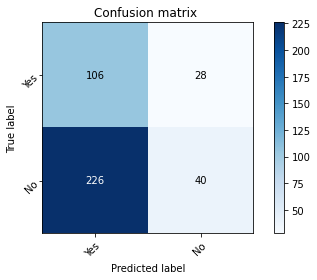

In [19]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, ["Yes", "No"])

**Decision Tree df1**

In [20]:
df1["Attrition"] = df2["Attrition"]

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4302 entries, 0 to 4448
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeNumber           4302 non-null   int64  
 1   BusinessTravel           4302 non-null   int64  
 2   DailyRate                4302 non-null   float64
 3   Department               4302 non-null   int64  
 4   Education                4302 non-null   float64
 5   EducationField           4302 non-null   int64  
 6   EnvironmentSatisfaction  4302 non-null   float64
 7   Gender                   4302 non-null   int64  
 8   HourlyRate               4302 non-null   float64
 9   JobInvolvement           4302 non-null   float64
 10  JobLevel                 4302 non-null   float64
 11  JobRole                  4302 non-null   int8   
 12  JobSatisfaction          4302 non-null   float64
 13  MaritalStatus            4302 non-null   int64  
 14  MonthlyIncome           

In [26]:
df1 = df1.dropna()
df2 = df2.dropna()

In [28]:
X_test = df1[-400:]
X_train = df1[:-400]

y_test = X_test["Attrition"]
y_train = X_train["Attrition"]

X_test.pop("Attrition")
X_train.pop("Attrition")

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3896    0.0
3897    0.0
3898    1.0
3899    0.0
3900    1.0
Name: Attrition, Length: 3122, dtype: float64

In [29]:
clf = DecisionTreeClassifier()


if 'EmployeeNumber' in X_train.columns:
    X_train.drop("EmployeeNumber", axis=1, inplace=True)

if 'EmployeeNumber' in X_test.columns:
    X_test.drop("EmployeeNumber", axis=1, inplace=True)

clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


DecisionTreeClassifier()

In [30]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


if 'EmployeeNumber' in X_train.columns:
    X_train.drop("EmployeeNumber", axis=1, inplace=True)

if 'EmployeeNumber' in X_test.columns:
    X_test.drop("EmployeeNumber", axis=1, inplace=True)

y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.37
  Precision: 0.4437275985663082
  Recall:    0.4559533161261362
  F1 score:  0.36228363194655333
  Mislabeled 252 out of 400




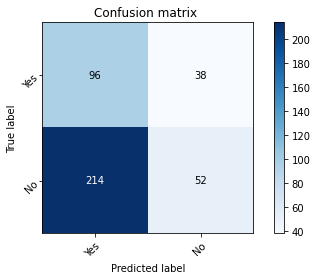

In [31]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, ["Yes", "No"])

**Concatenated**

In [32]:
merged = pd.merge(df1.drop("Attrition", axis=1), df2, on="EmployeeNumber")

In [33]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3522 entries, 0 to 3521
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeNumber            3522 non-null   int64  
 1   BusinessTravel            3522 non-null   int64  
 2   DailyRate                 3522 non-null   float64
 3   Department                3522 non-null   int64  
 4   Education                 3522 non-null   float64
 5   EducationField            3522 non-null   int64  
 6   EnvironmentSatisfaction   3522 non-null   float64
 7   Gender                    3522 non-null   int64  
 8   HourlyRate                3522 non-null   float64
 9   JobInvolvement            3522 non-null   float64
 10  JobLevel                  3522 non-null   float64
 11  JobRole                   3522 non-null   int8   
 12  JobSatisfaction           3522 non-null   float64
 13  MaritalStatus             3522 non-null   int64  
 14  MonthlyI

In [34]:
merged.head()

,EmployeeNumber,BusinessTravel,DailyRate,Department,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsWithCurrManager,Attrition,YearlyIncome
0,104,1,852.0,0,1.0,0,4.0,0,55.0,2.0,...,3.0,3.0,2.0,10.0,1.0,2.0,10.0,0.0,0,61512.0
1,1638,1,397.0,0,2.0,3,4.0,1,54.0,2.0,...,3.0,4.0,1.0,10.0,6.0,4.0,5.0,2.0,0,93072.0
2,164,1,841.0,0,3.0,5,3.0,1,46.0,2.0,...,3.0,3.0,0.0,5.0,3.0,2.0,5.0,3.0,0,28416.0
3,395,1,1117.0,0,2.0,0,4.0,1,66.0,3.0,...,4.0,4.0,0.0,5.0,3.0,3.0,5.0,2.0,0,39720.0
4,53,1,464.0,0,2.0,5,3.0,0,75.0,3.0,...,3.0,3.0,1.0,1.0,3.0,3.0,1.0,0.0,0,23412.0


In [35]:
X_test = merged[-400:]
X_train = merged[:-400]

y_test = X_test["Attrition"]
y_train = X_train["Attrition"]

X_test.pop("Attrition")
X_train.pop("Attrition")

0       0
1       0
2       0
3       0
4       0
       ..
3117    0
3118    0
3119    1
3120    0
3121    1
Name: Attrition, Length: 3122, dtype: int64

In [36]:
clf = DecisionTreeClassifier()


if 'EmployeeNumber' in X_train.columns:
    X_train.drop("EmployeeNumber", axis=1, inplace=True)

if 'EmployeeNumber' in X_test.columns:
    X_test.drop("EmployeeNumber", axis=1, inplace=True)

clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


DecisionTreeClassifier()

In [37]:
tree = DecisionTreeClassifier()

if 'EmployeeNumber' in X_train.columns:
    X_train.drop("EmployeeNumber", axis=1, inplace=True)

if 'EmployeeNumber' in X_test.columns:
    X_test.drop("EmployeeNumber", axis=1, inplace=True)

tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.3975
  Precision: 0.49835149370753085
  Recall:    0.498849736281001
  F1 score:  0.3850118978507314
  Mislabeled 241 out of 400




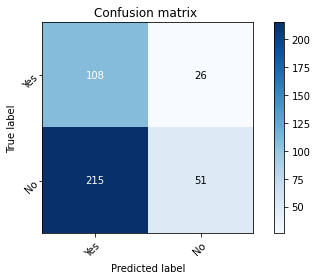

In [38]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, ["Yes", "No"])

In [39]:
df2 = df2[df2['YearsWithCurrManager'] > 40]
df2

,EmployeeNumber,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsWithCurrManager,Attrition,YearlyIncome
